In [264]:
import bpy
import os
import numpy as np
import matplotlib.pyplot as plt
import tempfile
from PIL import Image
import warnings
from helper_functies import *
from IPython.display import Image as JupImage
import imageio
import bmesh
import mathutils
from mathutils import Vector

tmpdir=tempfile.TemporaryDirectory()
size = [960, 1280]
my_dpi = 96 # Afhankelijk van monitor

# Preprocess of an obj ====================================================== #
def pre_obj(name):
    # Import an original obj file
    file_loc = 'obj/' + name[0] + '.obj'
    imported_object = bpy.ops.import_scene.obj(filepath = file_loc)
    
    # Export the obj file
    blend_file_path = bpy.data.filepath
    directory = os.path.dirname(blend_file_path)
    target_file = os.path.join(directory, name[1] + '.obj')
    bpy.ops.export_scene.obj(filepath='obj/' + name[1] + '.obj')

    # Remove a mtl file and the original obj file
    os.remove('obj/' + name[1] + '.mtl')
    bpy.ops.object.delete(use_global = False)
# ==================================================================== #


# Re-import the converted obj ======================================== #
def import_obj(name, n, obj, obj_data):
    # Re-Import the converted obj file
    file_loc = 'obj/'+ name[1] + '.obj'
    imported_object = bpy.ops.import_scene.obj(filepath = file_loc)

    #export_object = bpy.context.selected_objects[n[0]]
    export_object = bpy.context.selected_objects[0]
    
    # Shadow of object is removed
    export_object.active_material.use_cast_shadows = False
    
    # Add object and data
    obj.append(export_object)
    obj_data.append(bpy.data.objects[obj[n[0]].name]) 
    
    n[0] += 1
# ===================================================================== #


# Get an image ======================================================= #
def get_img(tmpdir=tmpdir, size=size, name='result'):
    scene = bpy.context.scene
    
    # Set resolution of x and y
    scene.render.resolution_x = size[0]
    scene.render.resolution_y = size[1]
    scene.render.resolution_percentage = 100
    scene.render.filepath=tmpdir.name+"/image"
    
    # Render the image
    bpy.ops.render.render(write_still=True)
    
    # Save the rendered image
    save_loc = "C:/Users/cglab/Anaconda3/envs/blender/RenderingModule/"+name+".png"
    bpy.data.images['Render Result'].save_render(filepath = save_loc)

    # Show the rendered image
    img=Image.open(tmpdir.name+"/image.png")
    return img
# ==================================================================== #


# Implement wireframe mode ============================================ #
def do_wireframe(object, n, mode=False):
    # do wireframe
    if mode:
        bpy.context.scene.render.use_freestyle = True
        bpy.context.scene.render.use_edge_enhance = True
        bpy.context.scene.render.edge_threshold = 1
        for i in range (0, n[0]):
            object[i].active_material.diffuse_color = (1, 1, 1)
            object[i].active_material.diffuse_intensity = 1
        
        # choose 'ABSOLUTE' or 'RELATIVE', I recommend 'ABSOLUTE'
        bpy.context.scene.render.line_thickness_mode = 'ABSOLUTE'
        bpy.context.scene.render.line_thickness = 0.5
        bpy.context.scene.world.horizon_color = (1, 1, 1)
        
    # do not wireframe
    else:
        bpy.context.scene.render.use_freestyle = False
        bpy.context.scene.render.use_edge_enhance = False
# ===================================================================== #


# Implement normal mode ================================================ #
def do_normal(object, n, mode=False):
    if mode:
        for i in range (0, n[0]):
            object[i].active_material.use_shadeless = True
        
            # Please, change a place with mc23.jpg
            realpath = r"C:\Users\cglab\Anaconda3\envs\blender\RenderingModule\mc23.jpg"
            try:
                img = bpy.data.images.load(realpath)
            except:
                raise NameError("Cannot load image %s" % realpath)

            # Create image texture from image
            cTex = bpy.data.textures.new("NORMAL", type='IMAGE')
            cTex.image = img

            # Create material note that it is not same as the "texture"
            mat = bpy.data.materials.new("NORMAL")

            # Add texture slot for color texture
            mtex = mat.texture_slots.add()
            mtex.texture = cTex
            mtex.texture_coords = 'NORMAL'
            mtex.use_map_color_diffuse = True
            mtex.use_map_color_emission = True
            mtex.emission_color_factor = 1.0
            mtex.use_map_density = False
            mtex.mapping = 'FLAT'

            # assign material to object
            object[i].data.materials.append(mat)

            # or overwrite an existing material slot via index operator
            object[i].data.materials[0] = mat
# ===================================================================== #


class Camera:
    def __init__(self, mode):
        self.camera_obj = bpy.data.objects['Camera']
        bpy.ops.object.empty_add(
                type='PLAIN_AXES', radius=1, view_align=False,
                location=(0, 0, 0),
                layers=(True, False, False, False, False, False, False,
                        False, False, False, False, False, False, False,
                        False, False, False, False, False, False)
                )
        
        # Perspective or Orthographic
        self.camera_obj.data.type = mode
        
        # Camera tracks to an object
        self.ttc = self.camera_obj.constraints.new(type='TRACK_TO')
        self.ttc.target = bpy.context.selected_objects[0]
        self.ttc.track_axis = 'TRACK_NEGATIVE_Z'
        self.ttc.up_axis = 'UP_Y'    
        
        self.x = 0
        self.y = 0
        self.z = 0
    
    def pos(self, r, theta, phi):
        # Spherical coord. is converted to cartesian coord.
        self.x = r * sin(theta * (math.pi/180)) * cos(phi * (math.pi/180))
        self.y = r * sin(theta * (math.pi/180)) * sin(phi * (math.pi/180))
        self.z = r * cos(theta * (math.pi/180))
    
        # Position of camera
        self.camera_obj.location.x = self.x
        self.camera_obj.location.y = self.y
        self.camera_obj.location.z = self.z

    def intrinsic(self, focal, shift_x, shift_y):
        if self.camera_obj.data.type == 'PERSP':
            self.camera_obj.data.lens = focal
            self.camera_obj.data.shift_x = shift_x
            self.camera_obj.data.shift_y = shift_y
        


# The position and mode of the camera ========================================== #
def camera_pos(r, theta, phi, mode, degree):
    # 
    camera_obj.constraints[ttc.name].owner_space = 'LOCAL'
    camera_obj.rotation_mode = 'AXIS_ANGLE'
    camera_obj.rotation_axis_angle[0] = degree * (math.pi/180)
    camera_obj.rotation_axis_angle[1] = 1    
    camera_obj.rotation_axis_angle[2] = 1    
    camera_obj.rotation_axis_angle[3] = 1    
# ====================================================================== #

In [269]:
zero(my_dpi)
# Set the light, RECOMMENDED TYPE :  SUN or POINT 
bpy.ops.object.lamp_add(type='SUN',location=(5,2,1))

# Set camera, obj, data, and the # of objects
camera = bpy.ops.object.camera_add()
obj = []
obj_data = []
n = [0]

# Preprocess of obj file
name_1 = ['test', 'test_b']
pre_obj(name_1)
# name_2 = ['chairpart1', 'chairpart1_b']
# pre_obj(name_2)

# Import the converted obj
import_obj(name_1, n, obj, obj_data)

# Object's location, rotation, scale
obj[0].location = (0, 0, 0)
#obj[0].rotation_euler = (0, 0, 0)
obj[0].scale = (0.0005, 0.0005, 0.0005)

# Change color of an object
obj_data[0].active_material.diffuse_color = (1, 1, 0)
obj_data[0].active_material.diffuse_intensity = 1

# # Second obj
# import_obj(name_2, n, obj, obj_data)
# obj[1].location = (0.2, 0.2, 0.2)
# #obj[1].rotation_euler = (0, 0, 0)
# obj[1].scale = (1, 1, 1)
# obj_data[1].active_material.diffuse_color = (0, 1, 1)
# obj_data[1].active_material.diffuse_intensity = 1

# (radius, theta, phi, obj_data, 'PERSP' or 'ORTHO')
# camera_pos(0.5, 90, 90, 'PERSP', 0) 

cam = Camera('PERSP')
cam.pos(0.5, 90, 90)
cam.intrinsic(35, 0, 0)

#Set the environment lighting and the color of background
bpy.context.scene.world.light_settings.use_environment_light = True
bpy.context.scene.world.horizon_color = (0, 0, 0)    # the color of background

# Implement Wireframe mode
do_wireframe(obj, n, True)

# Implement Normal mode
do_normal(obj, n, False)

(  0.0000 sec |   0.0000 sec) Importing OBJ 'obj/test.obj'...
  (  0.0010 sec |   0.0010 sec) Parsing OBJ file...
    (  0.0150 sec |   0.0140 sec) Done, loading materials and images...
	Material not found MTL: 'obj\\./test.obj.mtl'
    (  0.0160 sec |   0.0150 sec) Done, building geometries (verts:2181 faces:597 materials: 1 smoothgroups:0) ...
    (  0.0230 sec |   0.0220 sec) Done.
  (  0.0240 sec |   0.0240 sec) Finished importing: 'obj/test.obj'
Progress: 100.00%

    (  0.0010 sec |   0.0000 sec) OBJ Export path: 'obj/test_b.obj'
          (  0.0270 sec |   0.0260 sec) Finished writing geometry of 'test.062'.
          (  0.0270 sec |   0.0000 sec) Finished writing geometry of 'Camera.001'.
          (  0.0280 sec |   0.0010 sec) Finished writing geometry of 'Sun'.
          (  0.0280 sec |   0.0000 sec) Finished writing geometry of 'Camera'.
          (  0.0290 sec |   0.0000 sec) Finished writing geometry of 'Lamp'.
      (  0.0310 sec |   0.0300 sec) Finished exporting geometr

<Figure size 800x800 with 0 Axes>

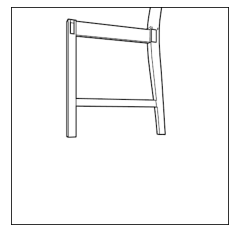

In [270]:
# Save and show Image
result_name = 'result'
# name the file
plt.imshow(get_img(size=[448, 448], name = result_name))    # save the file
plt.xticks([]);plt.yticks([])
plt.show()

tmpdir.cleanup()